In [21]:
from datetime import datetime, timedelta
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

dataset = pd.read_csv('dataset/Wallet id - Sheet1.csv')

In [22]:
dataset

,wallet_id
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3
1,0x06b51c6882b27cb05e712185531c1f74996dd988
2,0x0795732aacc448030ef374374eaae57d2965c16c
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae
...,...
98,0xf60304b534f74977e159b2e159e135475c245526
99,0xf67e8e5805835465f7eba988259db882ab726800
100,0xf7aa5d0752cfcd41b0a5945867d619a80c405e52
101,0xf80a8b9cfff0febf49914c269fb8aead4a22f847


In [23]:
def load_wallet_addresses():
    """Load the provided wallet addresses"""
    wallets_df = pd.read_csv('dataset/Wallet id - Sheet1.csv')
    return wallets_df
    

In [24]:
def generate_synthetic_transactions(wallets, num_transactions=10000):
    """Generate synthetic transaction data for demonstration"""
    np.random.seed(42)  # For reproducible results
    
    actions = ['deposit', 'borrow', 'repay', 'redeemunderlying']
    assets = ['USDC', 'USDT', 'DAI', 'WETH', 'WMATIC', 'AAVE']
    
    transactions = []
    
    for _ in range(num_transactions):
        wallet = np.random.choice(wallets['wallet_id'])
        action = np.random.choice(actions, p=[0.3, 0.25, 0.25, 0.2])  # Weighted probabilities
        asset = np.random.choice(assets)
        
        # Generate realistic amounts based on action type
        if action == 'deposit':
            amount = np.random.lognormal(mean=10, sigma=2)  # Higher amounts for deposits
        elif action == 'borrow':
            amount = np.random.lognormal(mean=9, sigma=1.5)  # Moderate amounts for borrows
        elif action == 'repay':
            amount = np.random.lognormal(mean=8.5, sigma=1.5)  # Similar to borrow
        else:  # redeemunderlying
            amount = np.random.lognormal(mean=9.5, sigma=1.8)
        
        # Generate timestamp (last 2 years)
        start_date = datetime.now() - timedelta(days=730)
        random_days = np.random.randint(0, 730)
        timestamp = start_date + timedelta(days=random_days)
        
        transactions.append({
            'userWallet': wallet,
            'action': action,
            'amount': amount,
            'asset': asset,
            'datetime': timestamp,
            'timestamp': int(timestamp.timestamp())
        })
    
    return pd.DataFrame(transactions)


In [25]:
def calculate_wallet_features(wallet_address, transactions_df):
    """Calculate comprehensive features for a wallet"""
    wallet_data = transactions_df[transactions_df['userWallet'] == wallet_address].copy()
    
    if len(wallet_data) == 0:
        return create_empty_features(wallet_address)
    
    # Basic transaction metrics
    total_transactions = len(wallet_data)
    
    # Separate transactions by type
    deposits = wallet_data[wallet_data['action'] == 'deposit']
    borrows = wallet_data[wallet_data['action'] == 'borrow']
    repays = wallet_data[wallet_data['action'] == 'repay']
    redeems = wallet_data[wallet_data['action'] == 'redeemunderlying']
    
    # Calculate amounts by transaction type
    total_deposit_amount = deposits['amount'].sum()
    total_borrow_amount = borrows['amount'].sum()
    total_repay_amount = repays['amount'].sum()
    total_redeem_amount = redeems['amount'].sum()
    
    # Transaction counts
    deposit_count = len(deposits)
    borrow_count = len(borrows)
    repay_count = len(repays)
    redeem_count = len(redeems)
    
    # Average amounts
    avg_deposit_amount = total_deposit_amount / deposit_count if deposit_count > 0 else 0
    avg_borrow_amount = total_borrow_amount / borrow_count if borrow_count > 0 else 0
    
    # Risk ratios
    borrow_to_deposit_ratio = total_borrow_amount / total_deposit_amount if total_deposit_amount > 0 else 0
    repay_to_borrow_ratio = total_repay_amount / total_borrow_amount if total_borrow_amount > 0 else 1
    
    # Activity metrics
    date_range = (wallet_data['datetime'].max() - wallet_data['datetime'].min()).days
    days_active = max(1, date_range)
    transaction_frequency = total_transactions / days_active
    
    # Asset diversity
    unique_assets = wallet_data['asset'].nunique()
    
    # Liquidation risk calculation
    liquidation_risk_score = min(100, borrow_to_deposit_ratio * 50 + (1 - repay_to_borrow_ratio) * 30)
    
    return {
        'wallet_id': wallet_address,
        'total_transactions': total_transactions,
        'total_deposit_amount': total_deposit_amount,
        'total_borrow_amount': total_borrow_amount,
        'total_repay_amount': total_repay_amount,
        'total_redeem_amount': total_redeem_amount,
        'deposit_count': deposit_count,
        'borrow_count': borrow_count,
        'repay_count': repay_count,
        'redeem_count': redeem_count,
        'avg_deposit_amount': avg_deposit_amount,
        'avg_borrow_amount': avg_borrow_amount,
        'borrow_to_deposit_ratio': borrow_to_deposit_ratio,
        'repay_to_borrow_ratio': repay_to_borrow_ratio,
        'transaction_frequency': transaction_frequency,
        'unique_assets': unique_assets,
        'days_active': days_active,
        'liquidation_risk_score': liquidation_risk_score
    }

In [26]:
def create_empty_features(wallet_address):
    """Create empty feature set for wallets with no transactions"""
    return {
        'wallet_id': wallet_address,
        'total_transactions': 0,
        'total_deposit_amount': 0,
        'total_borrow_amount': 0,
        'total_repay_amount': 0,
        'total_redeem_amount': 0,
        'deposit_count': 0,
        'borrow_count': 0,
        'repay_count': 0,
        'redeem_count': 0,
        'avg_deposit_amount': 0,
        'avg_borrow_amount': 0,
        'borrow_to_deposit_ratio': 0,
        'repay_to_borrow_ratio': 0,
        'transaction_frequency': 0,
        'unique_assets': 0,
        'days_active': 0,
        'liquidation_risk_score': 0
    }

In [27]:
def calculate_risk_score(row):
    """Calculate risk score (0-1000) based on multiple factors"""
    
    # Base score starts at 500 (neutral)
    score = 500
    
    # Factor 1: Borrow to Deposit Ratio (0-200 points)
    borrow_deposit_penalty = min(200, row['borrow_to_deposit_ratio'] * 200)
    score += borrow_deposit_penalty
    
    # Factor 2: Repayment Behavior (0-150 points reduction)
    repayment_bonus = row['repay_to_borrow_ratio'] * 150
    score -= repayment_bonus
    
    # Factor 3: Transaction Activity (0-100 points reduction)
    if row['total_transactions'] > 0:
        activity_bonus = min(100, np.log(row['total_transactions'] + 1) * 20)
        score -= activity_bonus
    
    # Factor 4: Asset Diversification (0-50 points reduction)
    diversity_bonus = min(50, row['unique_assets'] * 10)
    score -= diversity_bonus
    
    # Factor 5: Transaction Frequency (0-50 points)
    if row['transaction_frequency'] > 10:
        frequency_penalty = min(50, (row['transaction_frequency'] - 10) * 5)
        score += frequency_penalty
    
    # Factor 6: Liquidation Risk (direct addition)
    score += row['liquidation_risk_score']
    
    # Factor 7: Volume-based adjustment
    if row['total_deposit_amount'] > 0:
        volume_bonus = min(50, np.log(row['total_deposit_amount'] + 1) * 2)
        score -= volume_bonus
    
    # Ensure score is within 0-1000 range
    score = max(0, min(1000, score))
    
    return int(score)

In [28]:

def categorize_risk(score):
    """Categorize risk scores into Low, Medium, High"""
    if score <= 300:
        return 'Low Risk'
    elif score <= 600:
        return 'Medium Risk'
    else:
        return 'High Risk'


In [29]:
def create_visualizations(features_df):
    """Create comprehensive visualizations"""
    plt.figure(figsize=(15, 12))
    
    # Risk score histogram
    plt.subplot(3, 3, 1)
    plt.hist(features_df['risk_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Risk Score Distribution')
    plt.xlabel('Risk Score')
    plt.ylabel('Frequency')
    
    # Borrow to Deposit Ratio vs Risk Score
    plt.subplot(3, 3, 2)
    plt.scatter(features_df['borrow_to_deposit_ratio'], features_df['risk_score'], alpha=0.6, color='red')
    plt.title('Borrow/Deposit Ratio vs Risk Score')
    plt.xlabel('Borrow to Deposit Ratio')
    plt.ylabel('Risk Score')
    
    # Transaction Count vs Risk Score
    plt.subplot(3, 3, 3)
    plt.scatter(features_df['total_transactions'], features_df['risk_score'], alpha=0.6, color='green')
    plt.title('Transaction Count vs Risk Score')
    plt.xlabel('Total Transactions')
    plt.ylabel('Risk Score')
    
    # Repayment Ratio vs Risk Score
    plt.subplot(3, 3, 4)
    plt.scatter(features_df['repay_to_borrow_ratio'], features_df['risk_score'], alpha=0.6, color='purple')
    plt.title('Repayment Ratio vs Risk Score')
    plt.xlabel('Repay to Borrow Ratio')
    plt.ylabel('Risk Score')
    
    # Asset Diversity vs Risk Score
    plt.subplot(3, 3, 5)
    plt.scatter(features_df['unique_assets'], features_df['risk_score'], alpha=0.6, color='orange')
    plt.title('Asset Diversity vs Risk Score')
    plt.xlabel('Unique Assets')
    plt.ylabel('Risk Score')
    
    # Risk Categories Pie Chart
    plt.subplot(3, 3, 6)
    risk_categories = features_df['risk_category'].value_counts()
    plt.pie(risk_categories.values, labels=risk_categories.index, autopct='%1.1f%%')
    plt.title('Risk Category Distribution')
    
    # Transaction Volume Distribution
    plt.subplot(3, 3, 7)
    plt.hist(features_df['total_deposit_amount'], bins=20, alpha=0.7, color='lightgreen')
    plt.title('Deposit Amount Distribution')
    plt.xlabel('Total Deposit Amount')
    plt.ylabel('Frequency')
    plt.yscale('log')
    
    # Liquidation Risk vs Final Score
    plt.subplot(3, 3, 8)
    plt.scatter(features_df['liquidation_risk_score'], features_df['risk_score'], alpha=0.6, color='darkred')
    plt.title('Liquidation Risk vs Final Score')
    plt.xlabel('Liquidation Risk Score')
    plt.ylabel('Final Risk Score')
    
    # Transaction Frequency Distribution
    plt.subplot(3, 3, 9)
    plt.hist(features_df['transaction_frequency'], bins=20, alpha=0.7, color='gold')
    plt.title('Transaction Frequency Distribution')
    plt.xlabel('Transactions per Day')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('comprehensive_risk_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

=== Demo Wallet Risk Scoring System ===
Note: Using synthetic transaction data for demonstration
Loaded 103 wallet addresses
Generating synthetic transaction data...
Generated 15000 synthetic transactions
Calculating features for all wallets...
Calculating risk scores...

Results saved to:
- wallet_risk_scores.csv (final output)
- detailed_wallet_features.csv (detailed features)

=== Risk Scoring Summary ===
Risk score range: 0 - 481
Average risk score: 285.96
Median risk score: 289.00
Standard deviation: 87.09

Risk Category Distribution:
risk_category
Low Risk       58
Medium Risk    45
Name: count, dtype: int64

Top 10 Highest Risk Wallets:
                                     wallet_id  risk_score risk_category
9   0x1656f1886c5ab634ac19568cd571bc72f385fdf7         481   Medium Risk
77  0xb271ff7090b39028eb6e711c3f89a3453d5861ee         452   Medium Risk
83  0xcbbd9fe837a14258286bbf2e182cbc4e4518c5a3         447   Medium Risk
39  0x58c2a9099a03750e9842d3e9a7780cdd6aa70b86         4

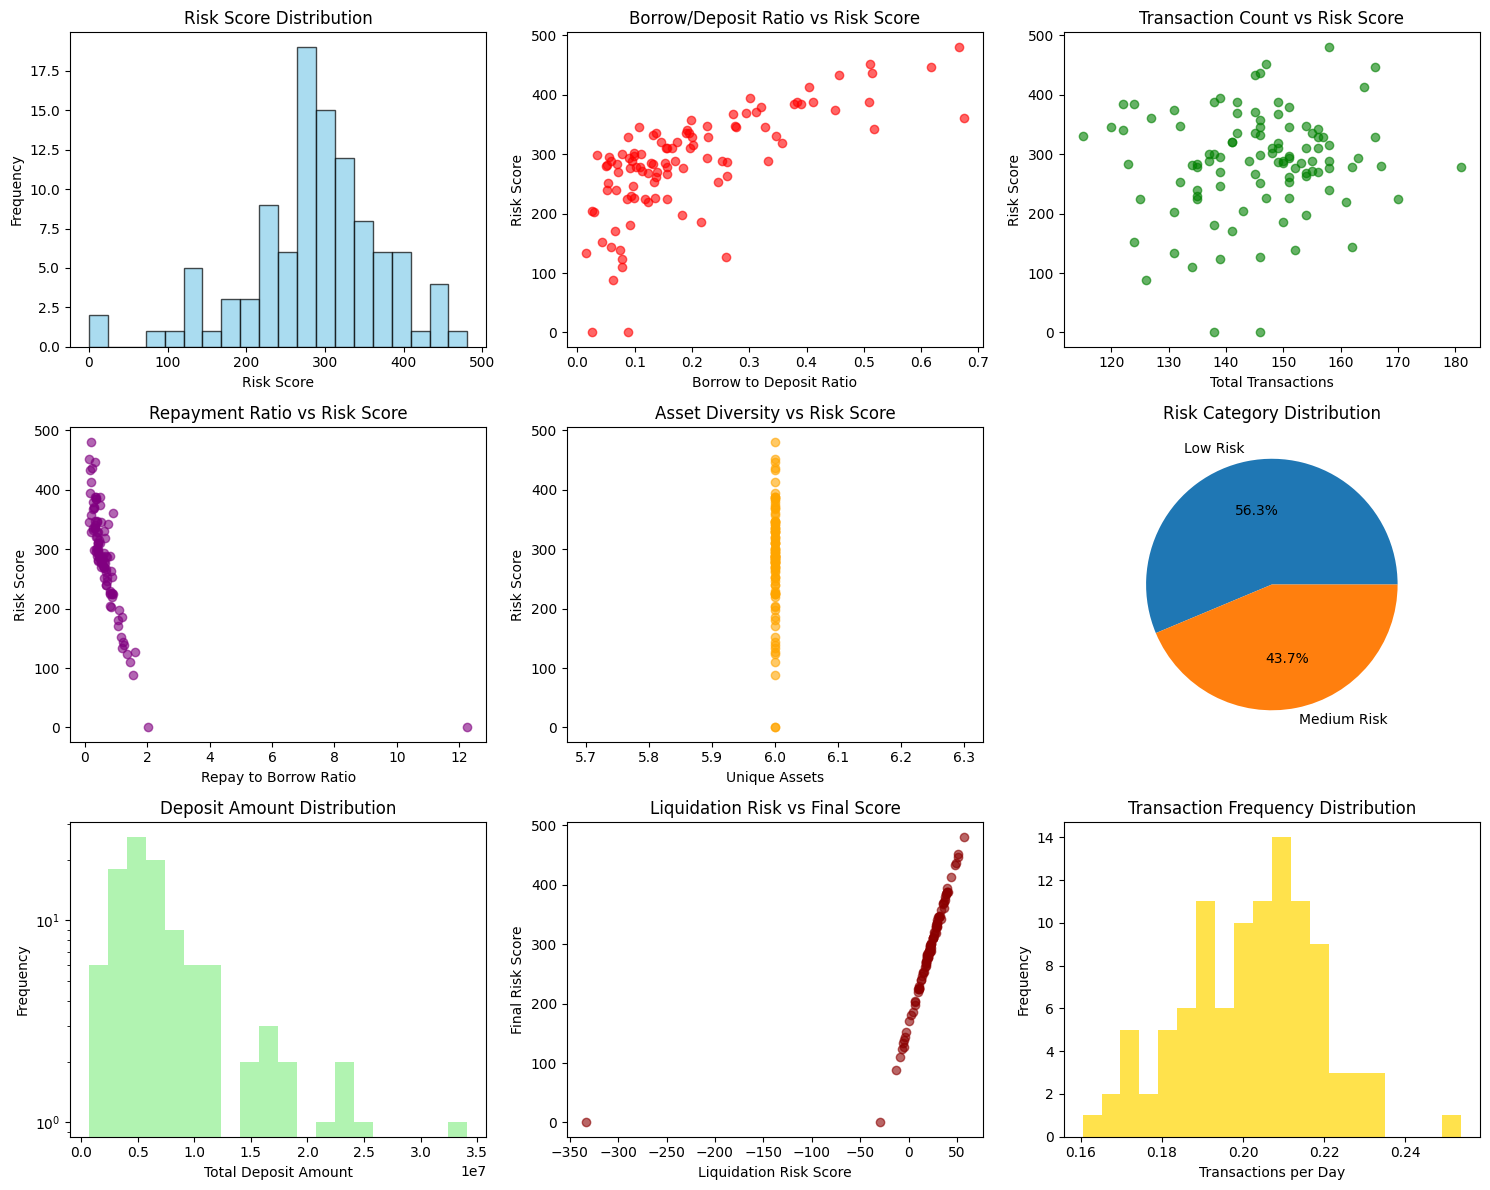


=== Analysis Complete ===
This demonstration shows how the risk scoring system would work with real transaction data.


In [30]:
"""Main execution function"""
print("=== Demo Wallet Risk Scoring System ===")
print("Note: Using synthetic transaction data for demonstration")
    
# Load wallet addresses
wallets_df = load_wallet_addresses()
print(f"Loaded {len(wallets_df)} wallet addresses")
    
# Generate synthetic transactions
print("Generating synthetic transaction data...")
transactions_df = generate_synthetic_transactions(wallets_df, num_transactions=15000)
print(f"Generated {len(transactions_df)} synthetic transactions")
    
# Calculate features for all wallets
print("Calculating features for all wallets...")
wallet_features = []
for wallet in wallets_df['wallet_id']:
    features = calculate_wallet_features(wallet, transactions_df)
    wallet_features.append(features)

# Convert to DataFrame
features_df = pd.DataFrame(wallet_features)

# Calculate risk scores
print("Calculating risk scores...")
features_df['risk_score'] = features_df.apply(calculate_risk_score, axis=1)
features_df['risk_category'] = features_df['risk_score'].apply(categorize_risk)

# Create final output
output_df = features_df[['wallet_id', 'risk_score']].copy()
output_df.columns = ['wallet_id', 'score']

# Save results
output_df.to_csv('wallet_risk_scores.csv', index=False)
features_df.to_csv('detailed_wallet_features.csv', index=False)

print(f"\nResults saved to:")
print("- wallet_risk_scores.csv (final output)")
print("- detailed_wallet_features.csv (detailed features)")

# Display summary statistics
print(f"\n=== Risk Scoring Summary ===")
print(f"Risk score range: {features_df['risk_score'].min()} - {features_df['risk_score'].max()}")
print(f"Average risk score: {features_df['risk_score'].mean():.2f}")
print(f"Median risk score: {features_df['risk_score'].median():.2f}")
print(f"Standard deviation: {features_df['risk_score'].std():.2f}")

print(f"\nRisk Category Distribution:")
print(features_df['risk_category'].value_counts())

print(f"\nTop 10 Highest Risk Wallets:")
top_risk = features_df.nlargest(10, 'risk_score')[['wallet_id', 'risk_score', 'risk_category']]
print(top_risk)

print(f"\nTop 10 Lowest Risk Wallets:")
low_risk = features_df.nsmallest(10, 'risk_score')[['wallet_id', 'risk_score', 'risk_category']]
print(low_risk)

# Create visualizations
print("\nGenerating comprehensive visualizations...")
create_visualizations(features_df)
    
print("\n=== Analysis Complete ===")
print("This demonstration shows how the risk scoring system would work with real transaction data.")
